In [1]:
import pandas as pd
import numpy as np
import os
import csv
import pickle
import glob
from itertools import combinations
from collections import defaultdict
from random import sample
import random
import seaborn as sns
import matplotlib.pyplot as plt
# import spearmanr
from scipy.stats import spearmanr, kendalltau

In [2]:
def collect_base_importance(exp_num, task='gilon_activity'):
    base_file_dirs = glob.glob(f"dataset/spearman_base_results/{task}/EXP{exp_num}/test_*/channel_test_attention_scores.csv")
    base_file_dirs.sort()

    base_importance_order = []
    for file_dir in base_file_dirs:
        file = pd.read_csv(file_dir).iloc[:,:-1]
        file = file.mean(axis=0)
        # get the importance idx of each channel
        base_importance_order.append(file.sort_values(ascending=False).index.tolist())
    return base_importance_order

In [3]:
shufflenet_gilon = collect_base_importance(1100)
resnet_gilon = collect_base_importance(1300)
mlpmixer_gilon = collect_base_importance(1500)
vit_gilon = collect_base_importance(1700)

In [4]:
shufflenet_qr_gilon = collect_base_importance(1200)
resnet_qr_gilon = collect_base_importance(1400)
mlpmixer_qr_gilon = collect_base_importance(1600)
vit_qr_gilon = collect_base_importance(1800)

In [5]:
# calculate the spearmanr of each model
def get_spearmanr(model_list):
    spearman_matrix = np.zeros((len(model_list), len(model_list)))
    for i in range(len(model_list)):
        for j in range(len(model_list)):
            spearman_matrix[i][j] = spearmanr(model_list[i], model_list[j])[0]
    # get only the upper triangle
    spearman_matrix = np.triu(spearman_matrix, k=1)
    # get mean and std
    mean = np.mean(spearman_matrix[spearman_matrix!=0])
    std = np.std(spearman_matrix[spearman_matrix!=0])
    return [mean, std]

In [6]:
def get_kendalltau(model_list):
    kendall_matrix = np.zeros((len(model_list), len(model_list)))
    for i in range(len(model_list)):
        for j in range(len(model_list)):
            kendall_matrix[i][j] = kendalltau(model_list[i], model_list[j])[0]
    # get only the upper triangle
    kendall_matrix = np.triu(kendall_matrix, k=1)
    # get mean and std
    mean = np.mean(kendall_matrix[kendall_matrix!=0])
    std = np.std(kendall_matrix[kendall_matrix!=0])
    return [mean, std]

In [7]:
def calculate_spearmanr_mean_std(model_list):
    spearmanr_list = []
    for model in model_list:
        spearmanr_list.append(get_spearmanr(model))
    return pd.DataFrame(spearmanr_list, columns=['mean', 'std'], index=['shufflenet', 'resnet', 'mlpmixer', 'vit'])

In [8]:
def calculate_kendalltau_mean_std(model_list):
    kendalltau_list = []
    for model in model_list:
        kendalltau_list.append(get_kendalltau(model))
    return pd.DataFrame(kendalltau_list, columns=['mean', 'std'], index=['shufflenet', 'resnet', 'mlpmixer', 'vit'])

In [9]:
calculate_spearmanr_mean_std([shufflenet_gilon, resnet_gilon, mlpmixer_gilon, vit_gilon])

/root/miniconda3/envs/vit/lib/python3.9/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


,mean,std
shufflenet,0.207033,0.230341
resnet,0.370549,0.248884
mlpmixer,0.330549,0.236311
vit,0.407033,0.125108


In [10]:
calculate_spearmanr_mean_std([shufflenet_qr_gilon, resnet_qr_gilon, mlpmixer_qr_gilon, vit_qr_gilon])

/root/miniconda3/envs/vit/lib/python3.9/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


,mean,std
shufflenet,0.352527,0.262024
resnet,0.581538,0.129634
mlpmixer,0.165714,0.366266
vit,0.502418,0.169077


In [11]:
calculate_kendalltau_mean_std([shufflenet_gilon, resnet_gilon, mlpmixer_gilon, vit_gilon])

/root/miniconda3/envs/vit/lib/python3.9/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


,mean,std
shufflenet,0.142857,0.182563
resnet,0.270330,0.208224
mlpmixer,0.239560,0.202198
vit,0.292308,0.107130


In [12]:
calculate_kendalltau_mean_std([shufflenet_qr_gilon, resnet_qr_gilon, mlpmixer_qr_gilon, vit_qr_gilon])

/root/miniconda3/envs/vit/lib/python3.9/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


,mean,std
shufflenet,0.270330,0.218855
resnet,0.441758,0.112153
mlpmixer,0.129670,0.285579
vit,0.389011,0.138584


In [13]:
# combine all lists
all_importance_order = shufflenet_gilon + resnet_gilon + mlpmixer_gilon + vit_gilon
all_importance_qr_order = shufflenet_qr_gilon + resnet_qr_gilon + mlpmixer_qr_gilon + vit_qr_gilon

In [14]:
def calculate_spearman(order):
    spearman = []
    for i in range(len(order)):
        for j in range(len(order)):
            spearman.append(spearmanr(order[i], order[j])[0])
    reshaped_spearman = np.array(spearman).reshape(len(order), len(order))
    return reshaped_spearman

In [15]:
def make_heatmap(spearman_list, color_bar=True, save_name=None):
    # plot the heatmap. blue for positive, red for negative
    plt.figure(figsize=(10,10))
    # rotate colorbar label
    if color_bar:
        sns.heatmap(spearman_list, cmap='RdBu_r', vmin=-1, vmax=1, center=0, square=True, linewidths=.5, 
                    cbar_kws={"shrink": .5, "ticks":[-1, -0.5, 0, 0.5, 1], "label": "Spearmanr", "fraction":0.1})
        cbar = plt.gcf().axes[-1]
        cbar.yaxis.set_ticks_position('left')
        cbar.yaxis.set_label_position('right')
        cbar.set_yticklabels(['-1', '-0.5', '0', '0.5', '1'], fontsize=12)
        cbar.set_ylabel('Spearmanr', rotation=270, labelpad=20, fontsize=15)
        # set larger colorbar size
        cbar.set_position([.85, .11, .03, .77])
    else:
        sns.heatmap(spearman_list, cmap='RdBu_r', vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar=False)

    # manually set each cell to have 0.1 width and 0.2 height
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_position([0.1, 0.1, 0.7, 0.7])
    

    linewidth =7 
    # make extra whitespace between 5 and 6
    plt.axvline(x=5, color='white', linewidth=linewidth)
    plt.axhline(y=5, color='white', linewidth=linewidth)
    plt.axvline(x=10, color='white', linewidth=linewidth)
    plt.axhline(y=10, color='white', linewidth=linewidth)
    plt.axvline(x=15, color='white', linewidth=linewidth)
    plt.axhline(y=15, color='white', linewidth=linewidth)
    plt.axvline(x=20, color='white', linewidth=linewidth)
    plt.axhline(y=20, color='white', linewidth=linewidth)
    # remove the ticks
    plt.xticks([])
    plt.yticks([])
    # place 'Shufflenet', 'Resnet', 'MLPMixer', 'ViT' as x and y ticks
    # set to dark grey
    plt.yticks([2.5, 7.5, 12.5, 17.5,], ['Shufflenet', 'Resnet', 'MLPMixer', 'ViT'], fontsize=22, fontweight='bold', color='#41403F')
    # place x ticks on top
    plt.tick_params(axis='x', which='both', top=True, bottom=False, labeltop=True, labelbottom=False)
    plt.xticks([2.5, 7.5, 12.5, 17.5,], ['Shufflenet', 'Resnet', 'MLPMixer', 'ViT'], fontsize=22, fontweight='bold', color='#41403F')

    if save_name:
        plt.savefig(f"results/spearman/{save_name}.png", dpi=300, bbox_inches='tight')

In [16]:
# calculate the spearmanr for every pair of importance order, plot them in a heatmap
spearmanr_list = []
for i in range(len(all_importance_order)):
    for j in range(len(all_importance_order)):
        spearmanr_list.append(spearmanr(all_importance_order[i], all_importance_order[j])[0])
spearmanr_list = np.array(spearmanr_list).reshape(len(all_importance_order), len(all_importance_order))

/root/miniconda3/envs/vit/lib/python3.9/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


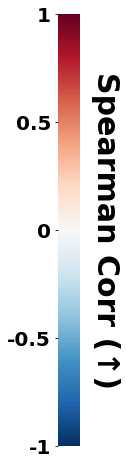

In [17]:
# plot the heatmap. blue for positive, red for negative
plt.figure(figsize=(10,10))
# rotate colorbar label
sns.heatmap(spearmanr_list, cmap='RdBu_r', vmin=-1, vmax=1, center=0, square=True, linewidths=.5, 
            cbar_kws={"shrink": .5, "ticks":[-1, -0.5, 0, 0.5, 1], "label": "Spearmanr", "fraction":0.1})

# get colorbar
cbar = plt.gcf().axes[-1]
cbar.yaxis.set_ticks_position('left')
cbar.yaxis.set_label_position('right')
# make bold
cbar.set_yticklabels(['-1', '-0.5', '0', '0.5', '1'], fontsize=20, fontweight='bold')
cbar.set_ylabel('Spearman Corr (\u2191)', rotation=270, labelpad=40, fontsize=30, fontweight='bold')
# set larger colorbar size
cbar.set_position([.85, .11, .03, .77])
# remove heatmap and leave only colorbar
plt.gca().set_visible(False)
# save 
plt.savefig("results/spearman/colorbar.png", dpi=300, bbox_inches='tight')



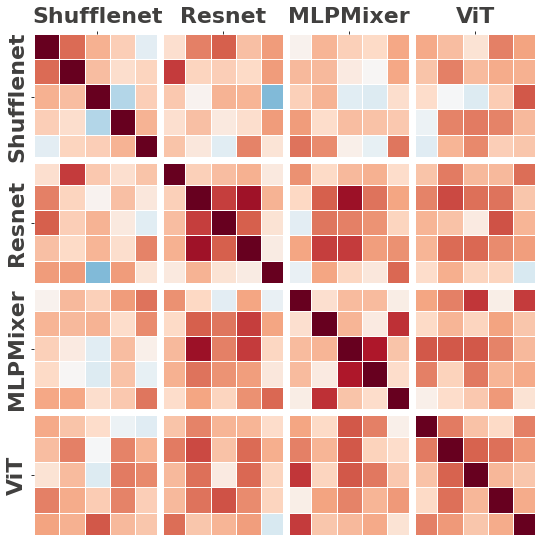

In [18]:
make_heatmap(spearmanr_list, False, save_name='GILON_without_QR')

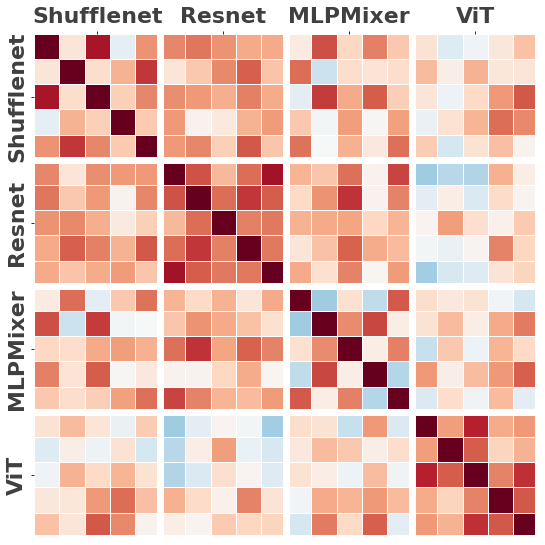

In [19]:
# calculate the spearmanr for every pair of importance order, plot them in a heatmap
spearmanr_qr_list = []
for i in range(len(all_importance_qr_order)):
    for j in range(len(all_importance_qr_order)):
        spearmanr_qr_list.append(spearmanr(all_importance_qr_order[i], all_importance_qr_order[j])[0])
spearmanr_qr_list = np.array(spearmanr_qr_list).reshape(len(all_importance_qr_order), len(all_importance_qr_order))

make_heatmap(spearmanr_qr_list, False, save_name='GILON_with_QR')


In [20]:
shufflenet_ms = collect_base_importance(3100, task='microsoft_activity_new')
resnet_ms = collect_base_importance(3300, task='microsoft_activity_new')
mlpmixer_ms = collect_base_importance(3500, task='microsoft_activity_new')
vit_ms = collect_base_importance(3700, task='microsoft_activity_new')

shufflenet_ms_qr = collect_base_importance(3200, task='microsoft_activity_new')
resnet_ms_qr = collect_base_importance(3400, task='microsoft_activity_new')
mlpmixer_ms_qr = collect_base_importance(3600, task='microsoft_activity_new')
vit_ms_qr = collect_base_importance(3800, task='microsoft_activity_new')

In [21]:
calculate_spearmanr_mean_std([shufflenet_ms, resnet_ms, mlpmixer_ms, vit_ms])

/root/miniconda3/envs/vit/lib/python3.9/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


,mean,std
shufflenet,0.062857,0.502857
resnet,-0.062857,0.528193
mlpmixer,-0.142857,0.355022
vit,-0.097143,0.519843


In [22]:
calculate_spearmanr_mean_std([shufflenet_ms_qr, resnet_ms_qr, mlpmixer_ms_qr, vit_ms_qr])

/root/miniconda3/envs/vit/lib/python3.9/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


,mean,std
shufflenet,0.640000,0.263168
resnet,0.440000,0.282033
mlpmixer,0.908571,0.077512
vit,0.120000,0.573254


In [23]:
calculate_kendalltau_mean_std([shufflenet_ms, resnet_ms, mlpmixer_ms, vit_ms])

/root/miniconda3/envs/vit/lib/python3.9/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


,mean,std
shufflenet,0.013333,0.462649
resnet,-0.066667,0.442217
mlpmixer,-0.093333,0.278408
vit,-0.066667,0.413118


In [24]:
calculate_kendalltau_mean_std([shufflenet_ms_qr, resnet_ms_qr, mlpmixer_ms_qr, vit_ms_qr])

/root/miniconda3/envs/vit/lib/python3.9/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


,mean,std
shufflenet,0.546667,0.280951
resnet,0.333333,0.273252
mlpmixer,0.813333,0.135974
vit,0.093333,0.483690


In [25]:
# combine all lists
all_importance_order_ms = shufflenet_ms + resnet_ms + mlpmixer_ms + vit_ms
all_importance_qr_order_ms = shufflenet_ms_qr + resnet_ms_qr + mlpmixer_ms_qr + vit_ms_qr

In [26]:
ms_base = calculate_spearman(all_importance_order_ms)
ms_qr = calculate_spearman(all_importance_qr_order_ms)

/root/miniconda3/envs/vit/lib/python3.9/site-packages/scipy/stats/_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


In [29]:
# print mean and std
print(f"Base Mean:{np.mean(ms_base)}, STD:{np.std(ms_base)}")
print(f"QR Mean:{np.mean(ms_qr)}. STD:{np.std(ms_qr)}")

Base Mean:0.03371428571428571, STD:0.539907475066472
QR Mean:0.45028571428571434. STD:0.4390921989556106


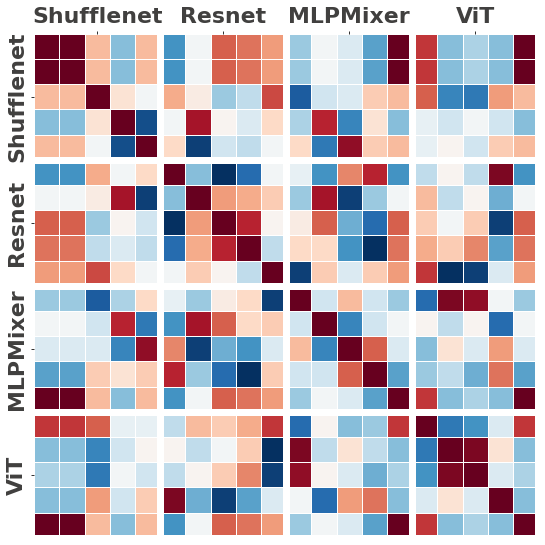

In [131]:
make_heatmap(ms_base, color_bar=False, save_name='MS_without_QR')

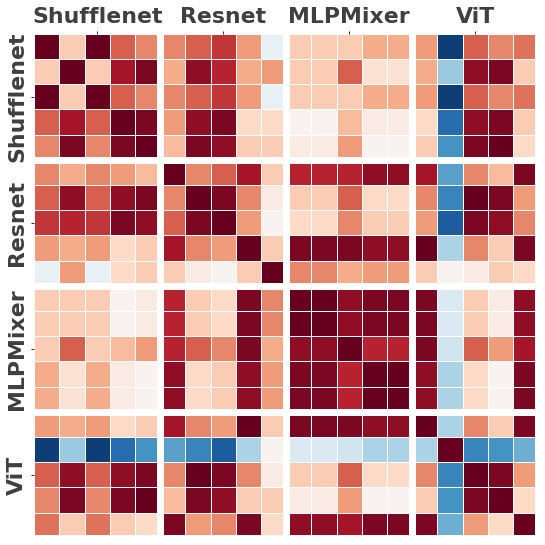

In [132]:
make_heatmap(ms_qr, color_bar=False, save_name='MS_with_QR')

<AxesSubplot:>

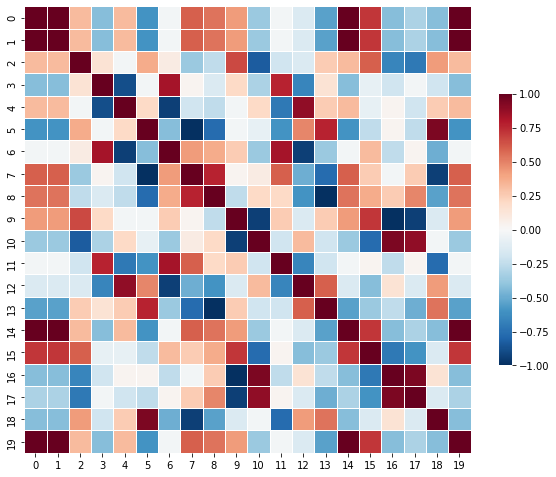

In [133]:
# plot the heatmap. blue for positive, red for negative
plt.figure(figsize=(10,10))
sns.heatmap(ms_base, cmap='RdBu_r', vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:>

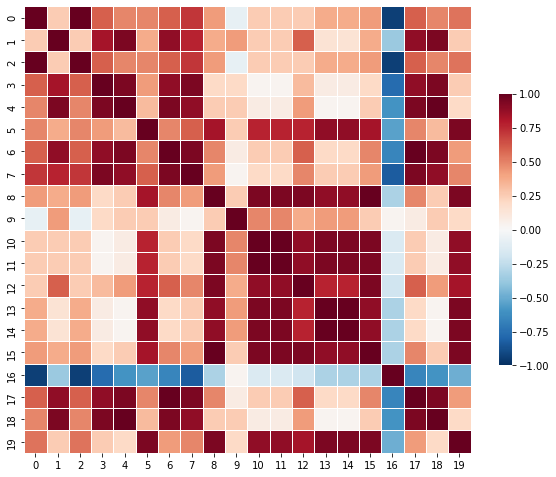

In [134]:
plt.figure(figsize=(10,10))
sns.heatmap(ms_qr, cmap='RdBu_r', vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# Draw ModelWise 